In [105]:
"""
pygraph.py

Un petit module pour créer des graphes (non orienté, orienté ou bi-partie)
Avec visualisation via Graphviz et possibilité de modifier quelques propriétés visuelles (couleur, forme, étiquette)

Auteur  : Sébastien Hoarau
Date    : 2021-08
Licence : CC BY-NC-SA 4.0 http://creativecommons.org/licenses/by-nc-sa/4.0/
Site    : gitlab.com/sebhoa/pygraph/

TODO
----
    - Plus de tests. Il reste probablement beaucoup de bugs à corriger
    - Ajouter d'autres algorithmes sur les graphes
    - traiter des graphes valués
"""

import graphviz as gv
import networkx as nx
import random
import string
# ----------
# CONSTANTES

# -- about shape and label
#
CIRCLE = 'circle'
SQUARE = 'square'
NOLABEL = ''

# Revoir plus tard le coup des emoji comme label
ANIMALS = ''.join([chr(n) for n in range(0x1f400,0x1f440)])
PEOPLE1 = ''.join([chr(n) for n in range(0x1f9d1, 0x1f9d5)]) 
PEOPLE2 = ''.join([chr(n) for n in range(0x1f466, 0x1f46a)])
PEOPLE3 = ''.join([chr(n) for n in range(0x1f474, 0x1f477)])
PEOPLE4 = chr(0x1f471)

# -- about colors

# color_id
WHITE = -1
LIGHTBLUE = 0
LEMONCHIFFON = 1
PINK1 = 2
LIGHTGREEN = 3
IVORY2 = 4
SIENNA1 = 5
BLACK = 6


# tuple of colors
COLORS = 'lightblue', 'lemonchiffon', 'pink1', 'lightgreen', 'ivory2', 'sienna1', 'black', 'white'

# -- about edges and nodes dimensions
ARROWSIZE = '0.5'
NODE_MARGIN = '0.02'
NODE_WIDTH = '0.3'
NODE_HEIGHT = '0.3'
SMALL_NODE_WIDTH = '0.1'
SMALL_NODE_HEIGHT = '0.1'

# -----------
# LES CLASSES

class NodeView:
    """
    La classe NodeView modélise les propriétés d'un noeud pour sa visualisation. 
    Cet objet est stocké comme information supplémentaire du modèle networkx
    
    Parameters
    ----------
        gv : graphviz.Graph | graphviz.Digraph
            la vue à laquelle cette vue noeud est rattachée
        node_id : int
            numéro identifiant le sommet
        color_id : int
            un numéro de couleur (valeur par défaut -1)
    """

    def __init__(self, gv, node_id, color_id=WHITE):        
        self.__gv = gv
        self.__id = node_id 
        self.__color_id = color_id
        self.__pos = None
        self.__label = str(node_id)
        self.__ech = 1
        self.__width = NODE_WIDTH
    
    # Public attributes
    
    @property
    def id(self):
        return self.__id
        
    @property
    def color_id(self):
        return self.__color_id
    
    @color_id.setter
    def color_id(self, color_id):
        self.__color_id = min(max(-len(COLORS), color_id), len(COLORS)-1)
    
    @property
    def pos(self):
        return self.__pos
    
    @pos.setter
    def pos(self, pos):
        self.__pos = pos
        
    @property
    def width(self):
        return self.__width
    
    @width.setter
    def width(self, width):
        self.__width = width

    @property
    def ech(self):
        return self.__ech
    
    @ech.setter
    def ech(self, ech):
        self.__ech = ech

    @property
    def label(self):
        return self.__label
    
    @label.setter
    def label(self, label):
        if not isinstance(label, str):
            label = str(self.id)
        self.__label = label
    
    @property
    def gv(self):
        return self.__gv
   
    
    # View modification methods
    
    def create(self):
        self.__gv.node(str(self.id), self.label, shape=CIRCLE, style='filled', fillcolor=self.color(), width=NODE_WIDTH, height=NODE_HEIGHT)
    
    
    # -- about labels
    
    def label_on(self, label = None):
        if label == None:
            self.__gv.node(str(self.id), self.label)
        else:
            self.__gv.node(str(self.id), label)

    def label_off(self):
        self.__gv.node(str(self.id), NOLABEL)
        
    def label_on_side(self, label = None):
        if label == None:
            self.__gv.node(str(self.id), xlabel=self.label)
        else:
            self.__gv.node(str(self.id), xlabel=label)

    def label_off_side(self):
        self.__gv.node(str(self.id), xlabel=NOLABEL)
        
    
    # -- about colors
    
    def color(self):
        return COLORS[self.color_id]
    
    def color_on(self, color=None):
        if isinstance(color, str):
            color_str = color
        elif isinstance(color, int):
            try:
                color_str = COLORS[color]
            except:
                color_str = COLORS[WHITE]
        else:
            color_str = self.color()
        self.__gv.node(str(self.id), style='filled', fillcolor=color_str)

    def color_off(self):
        self.__gv.node(str(self.id), style='filled', fillcolor=COLORS[WHITE])
        
        
    # -- about position and size
    
    def _is_positioned(self):
        return self.pos is not None

    def move(self, dx, dy):
        if self._is_positioned():
            self.pos = self.pos[0] + dx, self.pos[1] + dy

    def place(self, ech=None):
        if self._is_positioned():
            ech = self.ech if ech is None else ech
            self.ech = ech
            x, y = self.pos
            pos = f'{x*ech},{y*ech}!'
            self.__gv.node(str(self.id), pos=pos)
            
        
    def size(self, *dim):
        if len(dim) == 0:
            w, h = NODE_WIDTH, NODE_HEIGHT
            self.width = NODE_WIDTH
        elif len(dim) == 1:
            w, h = dim[0], dim[0]
            self.width = dim[0]
        else:
            w, h = dim
            width = dim[0]
        self.__gv.node(str(self.id), width=str(w), height=str(h))

    
class EdgeView:
    """
    La classe EdgeView modélise les propriétés d'une arête ou d'un arc pour sa visualisation. 
    Cet objet est stocké comme information supplémentaire du modèle networkx
    
    Parameters
    ----------
        gv : graphviz.Graph | graphviz.Digraph
            la vue à laquelle cette vue noeud est rattachée
        edge : 
            couple de node_id identifiant l'arc/arête
        color_id : int
            un numéro de couleur (valeur par défaut -1)
        weight : 
            La dimension l'attribut shape circle qui est égale à la hauteur
    """

    def __init__(self, gv, node_src, node_dst, weight = None, color_id=BLACK):        
        self.__gv = gv
        self.__edge = (node_src, node_dst)
        self.__color_id = color_id
        self.__weight = weight
        
    # Public attributes
    
    @property
    def edge(self):
        return self.__edge
        
    @property
    def color_id(self):
        return self.__color_id
    
    @color_id.setter
    def color_id(self, color_id):
        self.__color_id = min(max(-len(COLORS), color_id), len(COLORS)-1)

    @property
    def weight(self):
        return self.__weight
    
    @weight.setter
    def weight(self, weight):
        if not isinstance(weight, str):
            weight = str(self.weight)
        self.__weight = weight
    
    @property
    def gv(self):
        return self.__gv
   
    
    # View modification methods
    
    def create(self):
        if not self.weight:
            self.__gv.edge(str(self.edge[0]), str(self.edge[1]), style='filled', color=self.color())
        else:
            self.__gv.edge(str(self.edge[0]), str(self.edge[1]), str(self.weight), style='filled', color=self.color())
        
    
    # -- about colors
    
    def color(self):
        return COLORS[self.color_id]
    
    def color_on(self, color=None):
        if isinstance(color, str):
            color_str = color
        elif isinstance(color, int):
            try:
                color_str = COLORS[color]
            except:
                color_str = COLORS[BLACK]
        else:
            color_str = self.color()
        self.gv.edge(str(self.edge[0]), str(self.edge[1]), str(self.weight), style='filled', color=color_str)

    def color_off(self):
        self.__gv.edge(str(self.edge[0]), str(self.edge[1]), style='filled', color=COLORS[BLACK])
        
            
class Graph:
    """
    class Graph modélise un graphe non orienté dont le propriétés importantes sont :
    - model : un objet graphe au sens de networkx
    - view : un objet graphe au sens de graphviz
        
    Parameters:
    -----------
        nodes_count : int
            le nombre de sommets du graphe (par défaut 0)
        random : bool
            un flag pour savoir si le graphe généré est aléatoire. Si True alors le modèle sera 
            nx.erdos_renyi_graph(nodes_count, 0.5)
        engine : str
            le moteur de rendu (au sens de graphviz) ; par défaut 'neato'
    
    Note:
    -----
        Les autres paramètres ne devraient pas être utilisés : ils servent pour la création
        des graphes orientés et des graphes bi-partie
    """
        
    def __init__(self, nodes_count=0, random=False, directed=False, bipartite=False, n1=0, n2=0, engine='neato', strict=False):
        if random:
            self.__model = nx.erdos_renyi_graph(nodes_count, 0.5)
        elif directed:
            self.__model = nx.DiGraph()
        elif bipartite:
            self.__model = nx.complete_bipartite_graph(n1, n2)
        else:
            self.__model = nx.Graph()
        if directed:
            self.__view = gv.Digraph(engine=engine, strict=strict, edge_attr={'arrowsize':ARROWSIZE}, node_attr={'fixedsize':'true', 'width':NODE_WIDTH, 'height':NODE_HEIGHT, 'margin':NODE_MARGIN})
        else:
            self.__view = gv.Graph(engine=engine, strict=strict, node_attr={'fixedsize':'true', 'width':NODE_WIDTH, 'height':NODE_HEIGHT, 'margin':NODE_MARGIN})
        self.__engine = engine
        self.__model.add_nodes_from([node_id, {'view': None}] for node_id in range(nodes_count))
        self.init_view()
        
    
    @property
    def model(self):
        return self.__model
    
    @model.setter
    def model(self, model):
        self.__model = model
    
    @property
    def view(self):
        return self.__view
    
    @view.setter
    def view(self, view):
        self.__view = view

    @property
    def engine(self):
        return self.__engine
    
    @engine.setter
    def engine(self, engine):
        self.__engine = engine
    
    # MODEL METHODS
    
    # -- about information
    
    def node_ids(self):
        return self.model.nodes
    
    def edges(self):
        return self.model.edges
    
    def number_of_nodes(self):
        return self.model.number_of_nodes()

    def number_of_edges(self):
        return self.model.number_of_edges()
    
    # -- about adding elements
    
    def add_nodes(self, nodes_count=1):
        first = max(self.node_ids()) + 1
        for new_id in range(first, first+nodes_count):
            self.model.add_nodes_from([(new_id, {'g':self, 'view':NodeView(self.view, new_id)})])
            self.node_view(new_id).create()

    def add_edge(self, s1, s2): # A revoir
        self.model.add_edge(s1, s2)
        self.view.edge(str(s1), str(s2))
    
    def add_edges_from(self, iterable=None):
        for s in iterable:
            self.model.add_edges_from([(s[0],s[1], {'g':self, 'view':EdgeView(self.view, s[0],s[1])})])
            self.edge_view(*s).create()
            
    def add_weighted_edges_from(self, iterable=None):
        for s in iterable:
            self.model.add_edges_from([(s[0],s[1], {'weight':s[2], 'g':self, 'view':EdgeView(self.view, s[0],s[1],s[2])})])
            self.edge_view(s[0],s[1]).create()
    
    # -- about removing elements

    def remove_node(self, node_id):
        if node_id in self.node_ids():
            self.model.remove_node(node_id)
            self.reset_view()
    
    def remove_nodes_from(self, iterable):
        self.model.remove_nodes_from(iterable)
        self.reset_view()

    def remove_edge(self, s1, s2):
        self.model.remove_edge(s1, s2)
        self.reset_view()
    
    def remove_edges_from(self, iterable):
        self.model.remove_edges_from(iterable)
        self.reset_view()
    
    def remove_random_edges(self, edges_count):
        edges_count = min(edges_count, self.number_of_edges())
        list_of_edges = list(self.edges())
        random.shuffle(list_of_edges)
        self.remove_edges_from(list_of_edges[:edges_count])
        
    # -- copy of graph
    
    def copy(self):
        nodes_count = self.number_of_nodes()
        g = Graph(nodes_count, engine=self.engine)
        #g.init_view()
        if self.is_weighted():
            g.add_weighted_edges_from(self.weighted_edges())
        else:
            g.add_edges_from(self.edges())
            
        g.same_position_as(self)
        return g

    # -- other informations usefull for a lot of graphs algorithms
    
    def degree(self, node_id):
        return self.model.degree(node_id)
    
    def neighbors(self, node_id):
        return self.model.neighbors(node_id)
    
    # VIEW METHODS
    
    def node_view(self, node_id):
        return self.model.nodes[node_id]['view']
    
    def edge_view(self, node_src, node_dst):
        return self.model.edges[node_src, node_dst]['view']
    
    def init_view(self):
        self.init_nodes_view()
        self.init_edges_view()
        self.view_is_up_to_date = True
        
    def reset_view(self, engine=None, strict=False):
        engine = self.engine if engine is None else engine
        d_position = self.export_position()
        self.__view = gv.Graph(engine=engine, format='svg', strict=strict, node_attr={'fixedsize':'true', 'width':NODE_WIDTH, 'height':NODE_HEIGHT, 'margin':NODE_MARGIN})
        self.init_view()
        self.import_position(d_position)
        
    def init_nodes_view(self):
        for node_id in self.node_ids():
            self.model.nodes[node_id]['view'] = NodeView(self.view, node_id)
            self.node_view(node_id).create()


    def init_edges_view(self):
        for s1, s2, p in self.weighted_edges():
            self.model.edges[s1,s2]['view'] = EdgeView(self.view, s1,s2,p)
            self.edge_view(s1, s2).create()
            
    # -- about nodes positionning and resizing
    
    def position(self, iterable, ech=1):
        for node_id, *pos in iterable:
            self.node_view(node_id).pos = pos
        self.scale(ech)
        
    def scale(self, ech=None):
        for node_id in self.node_ids():
            self.node_view(node_id).place(ech)
        
    def same_position_as(self, g):
        for node_id in g.node_ids():
            if node_id in self.node_ids():
                node_view = self.node_view(node_id) 
                node_view.pos = g.node_view(node_id).pos
                node_view.ech = g.node_view(node_id).ech
                node_view.place()

    def _rec_move(self, node_ids, seen, dx, dy):
        if node_ids:
            node_id = node_ids.pop()
            self.node_view(node_id).move(dx, dy)
            seen.add(node_id)
            for v_id in self.neighbors(node_id):
                if v_id not in seen:
                    node_ids.add(v_id)
                    self._rec_move(node_ids, seen, dx, dy)
                    
    def move(self, node_id, dx, dy, group=False):
        if group:
            self._rec_move({node_id}, set(), dx, dy)
        else:
            self.node_view(node_id).move(dx, dy)
        self.scale()
    
    def resize(self, *dim, node_id=None):
        if node_id is None:
            for node_id in self.node_ids():
                self.node_view(node_id).size(*dim)
                if float(self.node_view(node_id).width) < 0.25:
                    self.node_view(node_id).label_off()
                    self.node_view(node_id).label_on_side(self.node_view(node_id).label)
                else:
                    self.node_view(node_id).label_on(self.node_view(node_id).label)
                    self.node_view(node_id).label_off_side()
        else:
            self.node_view(node_id).size(*dim)
            if float(self.node_view(node_id).width) < 0.25:
                self.node_view(node_id).label_off()
                self.node_view(node_id).label_on_side(self.node_view(node_id).label)
            else:
                self.node_view(node_id).label_on(self.node_view(node_id).label)
                self.node_view(node_id).label_off_side()
            
    def export_position(self):
        lnodes = list(self.node_ids())
        d = {node_id:self.node_view(node_id).pos for node_id in self.node_ids()}
        d['ech'] = self.node_view(lnodes[0]).ech if lnodes else 1
        return d

    def import_position(self, d_position):
        ech = d_position['ech']
        for node_id in self.node_ids():
            if node_id in d_position:
                self.node_view(node_id).pos = d_position[node_id]
                self.node_view(node_id).place(ech)

    # -- about labels
    
    def set_labels(self, labels=None):
        """
        Change all nodes label with the str labels parameter
        if labels is None, reset all labels to nodes ids
        """
        if labels is None:
            for node_id in self.node_ids():
                self.node_view(node_id).label = str(node_id)   
        elif isinstance(labels, str):
            nodes_count = self.number_of_nodes()
            labels += NOLABEL * max(0, nodes_count - len(labels))
            for node_id in self.node_ids():
                self.node_view(node_id).label = labels[node_id]
    
    def label_on(self):
        for node_id in self.node_ids():
            self.node_view(node_id).label_on()

    def label_off(self):
        for node_id in self.node_ids():
            self.node_view(node_id).label_off()
    
    # -- about colors

    def color_on(self, *args):
        if len(args) == 2:
            node_id, color = args
            self.node_view(node_id).color_on(color)
        else:
            for node_id in self.node_ids():
                self.node_view(node_id).color_on()

    def color_off(self):
        for node_id in self.node_ids():
            self.node_view(node_id).color_off()
            
    def color_on_edge(self, *args):
        if len(args) == 3:
            node_src, node_dst, color = args
            self.edge_view(node_src, node_dst).color_on(color)
        else:
            for node_src, node_dst in self.edges():
                self.edge_view(node_src, node_dst).color_on()

    def color_off_edge(self):
        for node_src, node_dst in self.edges():
            self.edge_view(node_src, node_dst).color_off()
            
    # -- about attibutes
    def is_weighted(self):
        # Return true if the graph is ponderate
        return nx.is_weighted(self.model)
    
    def get_node_attributes(self, node_id):
        return nx.get_node_attributes(self.model,node_id)
    
    def printGraphInfo(self):
        for node, info in self.model.adj.items():
            for voisin, info_lien in info.items(): 
                print(f"Lien [{node} et {voisin}] => poid {info_lien['weight']}")
    
    def weighted_edges(self):
        listE = list()
        res = list()
        for node, info in self.model.adj.items():
            for voisin, info_lien in info.items(): 
                listE.append(node)
                listE.append(voisin)
                listE.append(info_lien['weight'])
                res.append(listE)
                listE = list()
        return res         
    
        
    # -- write graph view in file
    
    def write(self, filename='output', format='svg'):
        self.view.render(filename, format=format, view=True)

        
    # CLASSIC ALGORITHMS HOMEMADE

    # -- utilitaries functions
    
    def _select_node(self, node_ids, fct):
        """sélectionne parmi node_ids le node_id qui maximise fct"""
        selected = node_ids[0]
        best_value = fct(selected)
        for i in range(1, len(node_ids)):
            node_id = node_ids[i]
            value = fct(node_id)
            if value > best_value:
                best_value = value
                selected = node_id
        return selected

    # -- BFS : Breadth First Search (parcours en largeur)

    def bfs(self, node_id):
        a_traiter = [[node_id]]
        seen = set()
        voisins = []
        while a_traiter:
            un_niveau = a_traiter.pop(0)
            voisins.append(un_niveau.copy())
            voisins_a_traiter = []
            for node in un_niveau:
                seen.add(node)
                node_voisins = list(self.neighbors(node))
                for n in node_voisins:
                    if n not in seen and n not in voisins_a_traiter:
                        voisins_a_traiter.append(n)
            if voisins_a_traiter:
                a_traiter.append(voisins_a_traiter)
        return voisins

    # -- DFS : Depth-First Search (parcours en profondeur)

    # todo

    # -- about graph coloration
    
    def dsat(self, node_id):
        """Retourne le nombre de couleurs différentes parmi les voisins"""
        return len({self.node_view(n_id).color_id for n_id in self.neighbors(node_id) if self.node_view(n_id).color_id != WHITE})
    
    def _smallest_color_id(self, node_id):
        color_id = 0
        used_color_ids = {self.node_view(v_id).color_id for v_id in self.neighbors(node_id)}
        while color_id in used_color_ids:
            color_id += 1
        return color_id
    
    def colorise(self, step=False):
        """Coloration du graph en uilisant l'algo DSATUR -- si step vaut True
        chaque étape de la coloration est sauvée dans un fichier"""
        node_ids = list(self.node_ids())
        node_id = self._select_node(node_ids, lambda i: self.degree(i))
        nb_color_used = 1
        color_id = 0
        self.node_view(node_id).color_id = color_id
        node_ids.remove(node_id)
        if step:
            nb_step = 1
            self.color_on()
            self.write(f'colorise_{nb_step:02}', format='png')
        while node_ids:
            node_id = self._select_node(node_ids, lambda i: (self.dsat(i), self.degree(i)))
            node_ids.remove(node_id)
            color_id = self._smallest_color_id(node_id)
            self.node_view(node_id).color_id = color_id
            if step:
                nb_step += 1
                self.color_on()
                self.write(f'colorise_{nb_step:02}', format='png')
            if color_id > nb_color_used - 1:
                nb_color_used = color_id + 1
        return nb_color_used
    
    # CLASSIC ALGORITHMS BY NETWORKX
    # see https://networkx.org/documentation/stable/reference/algorithms/index.html
    
    # -- Coloration
    
    def greedy_color(self, strategy):
        dict_colors = nx.greedy_color(self.model, strategy)
        print(dict_colors)
        for node_id, color_id in dict_colors.items():
            self.node_view(node_id).color_id = color_id
        return len(set(dict_colors.values()))
            
class DiGraph(Graph):
    """
    class DiGraph modélise un graphe orienté. 
    
    Parameters:
    -----------
        nodes_count : int
            le nombre de sommets du graphe (par défaut 0)
        engine : str
            le moteur de rendu
    
    Note:
    -----
        Appel le constructeur de Graph avec directed=True
    """

    
    def __init__(self, nodes_count=0, engine='neato', strict=False):
        Graph.__init__(self, nodes_count, random=False, directed=True, strict=strict, engine=engine)
        
    def reset_view(self, engine=None, strict=False):
        engine = self.engine if engine is None else engine
        d_position = self.export_position()
        self.view = gv.Digraph(engine=engine, strict=strict, edge_attr={'arrowsize':ARROWSIZE}, node_attr={'fixedsize':'true', 'width':NODE_WIDTH, 'height':NODE_HEIGHT, 'margin':NODE_MARGIN})
        self.init_view()
        self.import_position(d_position)

    def copy(self):
        nodes_count = self.number_of_nodes()
        g = DiGraph(nodes_count, engine=self.engine)
        g.init_view()
        if self.is_weighted():
            g.add_weighted_edges_from(self.weighted_edges())
        else:
            g.add_edges_from(self.edges())
        g.same_position_as(self)
        return g

    def degree(self, node_id):
        return len(self.neighbors(node_id))
    
    def neighbors(self, node_id):
        if self.is_weighted:
            neigh = self.model.neighbors(node_id)
        else:
            neigh = list(self.model.successors(node_id))
            neigh.extend(self.model.predecessors(node_id))
        return neigh

        
class BiPartite(Graph):
    """
    class BiPartite modélise un graphe bi-partie non orienté. 
    
    Parameters:
    -----------
        n1 : int
            le nombre de sommets d'une partie du graphe
        n2 : int
            le nombre de sommets de l'autre partie du graphe
        engine : str
            le moteur de rendu
    
    Note:
    -----
        Appel le constructeur de Graph avec nodes_count=n1+n2,directed=False, 
        random=False et bipartite=True
    """
    
    def __init__(self, n1, n2, engine='neato'):
        Graph.__init__(self, n1+n2, bipartite=True, n1=n1, n2=n2, engine=engine)
        self.n1 = n1
        self.n2 = n2
        
    def copy(self):
        nodes_count = self.number_of_nodes()
        g = Graph(nodes_count, bipartite=True, n1=self.n1, n2=self.n2, engine=self.engine)
        g.init_view()
        g.add_edges_from(self.edges())
        g.same_position_as(self)
        return g




In [106]:
from math import inf
from queue import PriorityQueue

class Dijkstra(Graph):
    """
    class Dijkstra
        
    Parameters:
    -----------
        Graph : Graph
            le graphe sur lequel on applique l'algorithme
        start : int
            le nœud de départ 
        end : int
            le nœud de destination
        solved : bool
            un flag pour savoir si la résolution du plus court chemin est achevé
        step_by_step : bool
            un flag pour savoir si on lance la résolutions du plus court chemin étape par étape
        shortest_path : list
            la liste des node_id du chemin le plus court 
        dist : dict
            dictionnaire contenant les clés: valeurs suivantes node_id: distance from start 
        pred : dict
            dictionnaire contenant les clés: valeurs suivantes node_id: son prédécesseur 
        visited : collection set
            collection des nœud visité         
    
    Note:
    -----
        Les autres paramètres ne devraient pas être utilisés : ils servent à l'exécution de l'algorithme.
    """
    
    def __init__(self, Graph, start, end):
        self.__Graph = Graph # Graphe 
        self.__start = start # Nœud de départ
        self.__end = end # Nœud de destination
        self.__step = False # Flag
        self.__solved = False # Flag
        self.__step_by_step = False # Mode d'affichage
        self.__shortest_path = list() # Path to use
        self.__dist = None # Distances
        self.__pred = None # Prédécesseurs
        self.__visited = None # Nœud visité
        self.priorityQueu = PriorityQueue() 
        self.init_dijkstra()
   
    # +++++GET/SET+++++ #
    @property
    def Graph(self):
        return self.__Graph

    @Graph.setter
    def Graph(self, Graph):
        self.__Graph = Graph
        
    @property
    def dist(self):
        return self.__dist

    @dist.setter
    def dist(self, dist):
        self.__dist = dist
        
    @property
    def visited(self):
        return self.__visited

    @visited.setter
    def visited(self, visited):
        self.__visited = visited
        
    @property
    def pred(self):
        return self.__pred

    @pred.setter
    def pred(self, pred):
        self.__pred = pred
        
    @property
    def shortest_path(self):
        return self.__shortest_path

    @shortest_path.setter
    def shortest_path(self, shortest_path):
        self.__shortest_path = shortest_path
        
    @property
    def step_by_step(self):
        return self.__step_by_step

    @step_by_step.setter
    def step_by_step(self, step_by_step):
        self.__step_by_step = step_by_step
        
    @property
    def solved(self):
        return self.__solved

    @solved.setter
    def solved(self, solved):
        self.__solved = solved
        
    @property
    def start(self):
        return self.__start

    @start.setter
    def start(self, start):
        self.__start = start
        
    @property
    def end(self):
        return self.__end

    @end.setter
    def end(self, end):
        self.__end = end
        
    @property
    def step(self):
        return self.__step

    @step.setter
    def step(self, step):
        self.__step = step
    # +++++GET/SET+++++ #
    
    
    # +++++TOOLS+++++ #    
    def view(self):
        return self.Graph.view
    
    def show_shortest_path(self):
        # Show the shortest path without other path
        Gtemp = self.Graph.copy()
        nodeList = list(self.Graph.model.nodes)
        res = list(self.Graph.model.nodes)
        for i in range(len(nodeList)):
            for x in range(len(self.shortest_path)):
                if nodeList[i] == self.shortest_path[x]:
                    res.remove(self.shortest_path[x])
        for i in range(len(res)):
            Gtemp.remove_node(res[i])
        return Gtemp.view
    # +++++TOOLS+++++ #   
    
    # +++++NETWORKX+++++ #               
    def path(self, src_node_id, dst_node_id):
        # Dijkstra : shortest weighted path, by networkx
        return nx.dijkstra_path(self.Graph.model, src_node_id, dst_node_id)

    def path_length(self, src_node_id, dst_node_id):
        # Dijkstra : Distance between 2 entry node : start , end, by networkx
        return nx.dijkstra_path_length(self.Graph.model, src_node_id, dst_node_id)
    
    def distance_nx(self, dst_node_id):
        # Dijkstra : Distance between start and an entry node, by networkx
        return nx.dijkstra_path_length(self.Graph.model, self.start, dst_node_id)
    
    def distance(self, dst_node_id):
        return self.dist[dst_node_id]
    
    def shortest_cost(self):
        # Dijkstra : Lenght of the shortest path by networkx
        return nx.dijkstra_path_length(self.Graph.model, self.start, self.end)
    # +++++NETWORKX+++++ #    
    
        
    # ------------------------Dijkstra---------------------# 
    
    # +++++INIT+++++ #
    def init_dijkstra(self):
        self.pred = {}  # Predecessor of the current node pos
        self.dist = {i: inf for i in list(nx.nodes(self.Graph.model))} # Init all nodes dist to inf except the source_node
        self.dist[self.start] = 0  # dist from start -> start is zero
        self.visited = set() 
        self.priorityQueu.put((self.dist[self.start], self.start))
        self.Graph.color_on(self.start, 3)
        self.Graph.resize(0.45)
        # Labelise all node 
        stre = str()
        for i in string.ascii_uppercase:
            if len(stre) <= self.Graph.number_of_nodes():
                stre += i
        self.Graph.set_labels(stre)
        self.Graph.label_on()
        print(self.dist)
    # +++++INIT+++++ #
    
    # +++++TOOLS+++++ #
    def next(self):
        if not self.solved:
            self.step = True
            self.solve()
        return self.view()
    
    def dijkstra_path(self):
        pos = self.end
        while pos != self.start:
            self.shortest_path.append(pos)
            pos = self.pred[pos]
        self.shortest_path.append(pos) 
        return self.shortest_path
    
    def color_dijkstra_path(self):
        self.Graph.color_off()
        for i in range(len(self.shortest_path)):
            if i == 0:
                self.Graph.color_on(self.shortest_path[i], 3)
            elif i >= (len(self.shortest_path)-1):
                self.Graph.color_on(self.shortest_path[i], 5)
            else :
                self.Graph.color_on(self.shortest_path[i], 2)
    
    def cost_between(self, start, end):
        # Return :Weight between 2 nodes
        return self.Graph.edge_view(start,end).weight
    
    def reset_dijkstra(self):
        # Reset dijkstra & view
        self.Graph.reset_view()
        self.step = False
        self.solved = False
        self.step_by_step = False
        self.shortest_path = list() # Path to use
        self.dist = None
        self.pred = None
        self.visited = None
        self.priorityQueu = PriorityQueue() 
        self.init_dijkstra()
    # +++++TOOLS+++++ #
    
    def dijkstra_step(self, boolean):
        # Dijkstra :step , Found the best path, save attributes{dist, pred, visited, shortest_path}
        if not boolean:
            pos_weight, pos = self.priorityQueu.get()
            self.visited.add(pos)
            # Adj() of the current node pos
            for neighbor in self.Graph.neighbors(pos):
                # New shortest path
                path = self.dist[pos] + self.cost_between(pos, neighbor)
                print(f"From[{self.start}] Pos[{self.Graph.node_view(pos).label}] to[{neighbor}] : => : from_pos[{self.dist[pos]}] + next_cost[{self.cost_between(pos, neighbor)}] = {path}")
                string = (f"{self.Graph.node_view(pos).label}{path}{self.Graph.node_view(neighbor).label}")
                if path < self.dist[neighbor]:
                    # Update distances
                    self.dist[neighbor] = path
                    # Update predecessor
                    self.pred[neighbor] = pos
                    self.Graph.color_on(pos, 3)
                    for i in explo.Graph.model.predecessors(pos):
                        self.Graph.color_on(i, 2)
                    self.Graph.node_view(neighbor).label_on(string)
                    # Unvisited neighbors
                    if neighbor not in self.visited:
                        self.visited.add(neighbor)
                        self.priorityQueu.put((self.dist[neighbor],neighbor))
                    else:
                        # Update queu
                        _ = self.priorityQueu.get((self.dist[neighbor],neighbor))
                        self.priorityQueu.put((self.dist[neighbor],neighbor))
            print(self.dist)
            if self.priorityQueu.qsize() == 0:
                self.solved = True
        else :
            pos_weight, pos = self.priorityQueu.get()
            self.visited.add(pos)
            for neighbor in self.Graph.neighbors(pos):
                path = self.dist[pos] + self.cost_between(pos, neighbor)
                print(f"From[{self.start}] Pos[{pos}] to[{neighbor}] : => : from_pos[{self.dist[pos]}] + next_cost[{self.cost_between(pos, neighbor)}] = {path}")
                string = (f"{self.Graph.node_view(pos).label}{path}{self.Graph.node_view(neighbor).label}")
                if path < self.dist[neighbor]:
                    self.dist[neighbor] = path
                    self.pred[neighbor] = pos
                    self.Graph.node_view(neighbor).label_on(string)
                    if neighbor not in self.visited:
                        self.visited.add(neighbor)
                        self.priorityQueu.put((self.dist[neighbor],neighbor))
                    else:
                        _ = self.priorityQueu.get((self.dist[neighbor],neighbor))
                        self.priorityQueu.put((self.dist[neighbor],neighbor))
            print(self.dist)
            if self.priorityQueu.qsize() == 0:
                self.solved = True
              
    def solve(self, step_by_step = True):
        # Dijkstra :main
        while not self.solved and self.step == True and step_by_step:
            self.step = False
            self.dijkstra_step(False)
                        
        while not self.solved and not step_by_step:
            self.dijkstra_step(True)
                        
        if self.solved:
            self.dijkstra_path()
            print(f"Le chemin le plus court entre {self.start} et {self.end} est le suivant : {self.shortest_path} avec une distance total de : {self.shortest_cost()}")
            self.color_dijkstra_path()
        return self.view()
    # ------------------------Dijkstra---------------------#  
    

Test de `EdgeView`

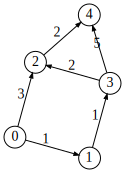

In [107]:
G = DiGraph(5, strict=True)
G.add_weighted_edges_from([(0,1,1), (1,3,1), (3,2,2), (3,4,5), (2,4,2), (0,2,3)])
G.view

In [108]:
G.edge_view(0,1).color_on(3) # Error here :TODO

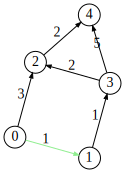

In [109]:
G.view

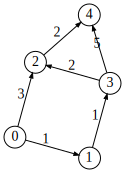

In [110]:
mon_graphe = DiGraph(5)
mon_graphe.add_weighted_edges_from([(0,1,1), (1,3,1), (3,2,2), (3,4,5), (2,4,2), (0,2,3)])
mon_graphe.view

In [111]:
explo = Dijkstra(mon_graphe, 0,4) # Objet Dijkstra

{0: 0, 1: inf, 2: inf, 3: inf, 4: inf}


In [112]:
explo.start

0

In [113]:
explo.end

4

In [114]:
explo.solved

False

In [115]:
explo.distance(0)

0

In [116]:
explo.distance(explo.end)

inf

In [117]:
explo.distance(4) == explo.shortest_cost()

False

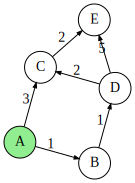

In [118]:
explo.view()

In [119]:
explo.solved

False

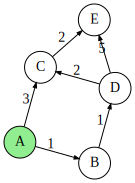

In [120]:
explo.solve()

In [121]:
explo.distance(0)

0

From[0] Pos[A] to[1] : => : from_pos[0] + next_cost[1] = 1
From[0] Pos[A] to[2] : => : from_pos[0] + next_cost[3] = 3
{0: 0, 1: 1, 2: 3, 3: inf, 4: inf}


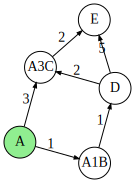

In [122]:
explo.next()

From[0] Pos[B] to[3] : => : from_pos[1] + next_cost[1] = 2
{0: 0, 1: 1, 2: 3, 3: 2, 4: inf}


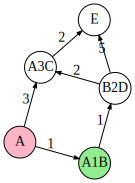

In [123]:
explo.next()

In [124]:
#explo.next()
explo.cost_between(3,4)

5

From[0] Pos[D] to[2] : => : from_pos[2] + next_cost[2] = 4
From[0] Pos[D] to[4] : => : from_pos[2] + next_cost[5] = 7
{0: 0, 1: 1, 2: 3, 3: 2, 4: 7}


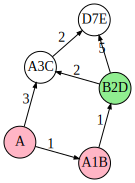

In [125]:
explo.next()

From[0] Pos[C] to[4] : => : from_pos[3] + next_cost[2] = 5
{0: 0, 1: 1, 2: 3, 3: 2, 4: 5}


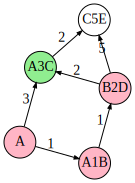

In [126]:
explo.next()

{0: 0, 1: 1, 2: 3, 3: 2, 4: 5}
Le chemin le plus court entre 0 et 4 est le suivant : [4, 2, 0] avec une distance total de : 5


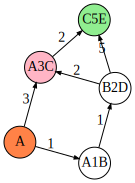

In [127]:
explo.next()

In [128]:
explo.reset_dijkstra()

{0: 0, 1: inf, 2: inf, 3: inf, 4: inf}


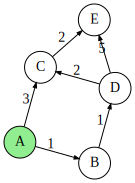

In [129]:
explo.view()

From[0] Pos[0] to[1] : => : from_pos[0] + next_cost[1] = 1
From[0] Pos[0] to[2] : => : from_pos[0] + next_cost[3] = 3
{0: 0, 1: 1, 2: 3, 3: inf, 4: inf}
From[0] Pos[1] to[3] : => : from_pos[1] + next_cost[1] = 2
{0: 0, 1: 1, 2: 3, 3: 2, 4: inf}
From[0] Pos[3] to[2] : => : from_pos[2] + next_cost[2] = 4
From[0] Pos[3] to[4] : => : from_pos[2] + next_cost[5] = 7
{0: 0, 1: 1, 2: 3, 3: 2, 4: 7}
From[0] Pos[2] to[4] : => : from_pos[3] + next_cost[2] = 5
{0: 0, 1: 1, 2: 3, 3: 2, 4: 5}
{0: 0, 1: 1, 2: 3, 3: 2, 4: 5}
Le chemin le plus court entre 0 et 4 est le suivant : [4, 2, 0] avec une distance total de : 5


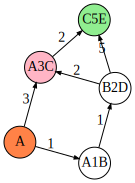

In [130]:
explo.solve(False)

In [131]:
explo.shortest_path

[4, 2, 0]

In [132]:
explo.dist

{0: 0, 1: 1, 2: 3, 3: 2, 4: 5}

In [133]:
explo.pred

{1: 0, 2: 0, 3: 1, 4: 2}

In [134]:
explo.visited

{0, 1, 2, 3, 4}

In [135]:
explo.distance(explo.end)

5

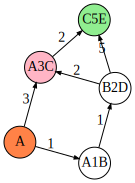

In [136]:
explo.view()